# Group-Based TWO CLASS Prediction XGBoost

This notebook implements the ML algorithm that identifies customers affected (<=100, >100)

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import re
from fuzzywuzzy import process
from sklearn.metrics.pairwise import haversine_distances
from itertools import permutations
from itertools import combinations
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold



## Load Data 

Fix Datatype of Year into string and Job OFF Time as datatime

In [2]:
file_path = 'Data/'
df = pd.read_csv(file_path+'IncidentDataFinal.csv')

In [3]:
df['Year'] = df['Year'].map(lambda x: str(x))
df['Job OFF Time'] = pd.to_datetime(df['Job OFF Time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264458 entries, 0 to 264457
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Substation ID                           264458 non-null  int64         
 1   PLANTCLASS                              264458 non-null  object        
 2   no_cities                               264458 non-null  int64         
 3   prior_incident_count                    264458 non-null  int64         
 4   Call Qty                                264410 non-null  float64       
 5   Job Substation                          264458 non-null  object        
 6   X                                       264458 non-null  float64       
 7   avg_line_voltage                        264458 non-null  float64       
 8   OGE Causes                              264458 non-null  object        
 9   Y                                    

## Identifying features and target column
Divide features into following:
- Node features
- Network (topological) features
- Prior Incident features
- Incident features
- Cause features

For classification problems, only node, network and prior incident features are used (others are unavailable prior to incident

In [4]:
# df['Cust_Class'] = df['Custs Affected'].apply(lambda x: 0 if x<=100 else 1)

In [5]:
df['Cust_Class'].value_counts()

Cust_Class
0    246073
1     18385
Name: count, dtype: int64

In [6]:
#divide the data into training and testing

node_features= ['X','Y','Voltage','Distribution, Substation, Transmission','Job Substation', 'Substation ID','PLANTSTATU', 'no_feeders','no_cities']#,'PLANTCLASS']
network_features= ['total_line_length','avg_line_voltage','num_connections']
prior_incident_features = ['prior_avg_cust_affected','prior_avg_downtime','prior_incident_count','prior_avg_no_calls']# removing 'prior_avg_cmi'

incident_features= ['Call Qty','Job Duration Mins', 'Custs Affected','Year', 'Major Storm Event  Y (Yes) or N (No)'] #removing CMI
cause_features = ['OGE Causes','Equip Desc']
target_column = 'Cust_Class'
training_columns = node_features+network_features+prior_incident_features+cause_features
training_columns

['X',
 'Y',
 'Voltage',
 'Distribution, Substation, Transmission',
 'Job Substation',
 'Substation ID',
 'PLANTSTATU',
 'PLANTCLASS',
 'no_feeders',
 'no_cities',
 'total_line_length',
 'avg_line_voltage',
 'num_connections',
 'prior_avg_cust_affected',
 'prior_avg_downtime',
 'prior_incident_count',
 'prior_avg_no_calls',
 'OGE Causes',
 'Equip Desc']

### Encoding
Encoding the object columns using one-hot encoding and renaming the resulting columns to shorter names


In [7]:
#one hot encode categorical columns
#data_encoded = pd.get_dummies(df[training_columns+[target_column]], columns=['Distribution, Substation, Transmission','PLANTSTATU','PLANTCLASS'], drop_first=True)
data_encoded = pd.get_dummies(df[training_columns+[target_column]], columns=['Distribution, Substation, Transmission','PLANTSTATU'], drop_first=True)

#label encode cause columns
# Apply LabelEncoder to each column
for col in cause_features:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])


In [8]:
# #changing into shorter names 
# rename_map = {'Distribution, Substation, Transmission_DISTRIBUTION': 'DISTRIBUTION',
#               'Distribution, Substation, Transmission_SUBSTATION': 'SUBSTATION',
#               'Distribution, Substation, Transmission_TRANSMISSION':'TRANSMISSION',
#               'Major Storm Event  Y (Yes) or N (No)_Load Shed 1': 'MajorStormEvent_LS1',
#               'Major Storm Event  Y (Yes) or N (No)_Load Shed 2': 'MajorStormEvent_LS2',
#               'Major Storm Event  Y (Yes) or N (No)_N' : 'MajorStormEvent_N',
#               'Major Storm Event  Y (Yes) or N (No)_Y':'MajorStormEvent_Y'}

# data_encoded.rename(columns=rename_map,inplace=True)

# data_encoded[['SUBSTATION','TRANSMISSION','PLANTSTATU_S','PLANTCLASS_DD','PLANTCLASS_T']]= data_encoded[['SUBSTATION','TRANSMISSION','PLANTSTATU_S','PLANTCLASS_DD','PLANTCLASS_T']].map(lambda x: int(x))  

In [8]:
#changing into shorter names 
rename_map = {'Distribution, Substation, Transmission_DISTRIBUTION': 'DISTRIBUTION',
              'Distribution, Substation, Transmission_SUBSTATION': 'SUBSTATION',
              'Distribution, Substation, Transmission_TRANSMISSION':'TRANSMISSION'}

data_encoded.rename(columns=rename_map,inplace=True)

# data_encoded[['SUBSTATION','TRANSMISSION','PLANTSTATU_S','PLANTCLASS_DD','PLANTCLASS_T']]= data_encoded[['SUBSTATION','TRANSMISSION','PLANTSTATU_S','PLANTCLASS_DD','PLANTCLASS_T']].map(lambda x: int(x))  
data_encoded[['SUBSTATION','TRANSMISSION','PLANTSTATU_S']]= data_encoded[['SUBSTATION','TRANSMISSION','PLANTSTATU_S']].map(lambda x: int(x))  

## Using XGBoost Model to train and test classes

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop(['Substation ID','Job Substation',target_column],axis=1), data_encoded[target_column], test_size=0.2, random_state=42)
y_train.info()


<class 'pandas.core.series.Series'>
Index: 211566 entries, 7865 to 121958
Series name: Cust_Class
Non-Null Count   Dtype
--------------   -----
211566 non-null  int64
dtypes: int64(1)
memory usage: 3.2 MB


In [10]:
y_test

93013     1
3099      0
160931    0
152657    0
164363    1
         ..
75211     0
213977    0
81871     0
217226    0
144978    0
Name: Cust_Class, Length: 52892, dtype: int64

In [11]:
# # Create an XGBoost DMatrix (optimized data structure for XGBoost)
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)


# # Define XGBoost parameters
# param = {
#     'objective': 'binary:hinge',  # Multi-class classification
#     'eval_metric': 'logloss',    # Evaluation metric
#     'eta': 0.1,                   # Learning rate
#     'max_depth': 4                # Maximum depth of a tree
# }

# # Train the XGBoost model
# num_round = 100  # Number of boosting rounds
# bst = xgb.train(param, dtrain, num_round)

# # Make predictions on the test set

# preds = bst.predict(dtest)

## Performing Grid search in 4 stages
- Stage 1: n_estimators and learning rate
- Stage 2: max_depth, min_child_weight, gamma
- Stage 3: subsample, colsample_bytree
- Stage 4: reg_alpha, reg_lambda

In [12]:
scale_pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

bst = xgb.XGBClassifier(
    objective= 'binary:logistic',  # Multi-class classification
    eval_metric= 'logloss',
    # scale_pos_weight=scale_pos_weight, # Set the scale_pos_weight
    random_state = 42)

# Define the parameter grid for Stage 1
param_grid_stage1 = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.1, 0.05]
}

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run GridSearchCV for Stage 1
print("Running Stage 1: Tuning n_estimators and learning_rate...")
grid_search1 = GridSearchCV(
    estimator=bst,
    param_grid=param_grid_stage1,
    scoring='roc_auc_ovr_weighted',
    n_jobs=-1,
    cv=kfold,
    verbose=0
)

grid_search1.fit(X_train, y_train)

best_params_stage1 = grid_search1.best_params_
print(f"Stage 1 Best Parameters: {best_params_stage1}")
print("-" * 50)


Running Stage 1: Tuning n_estimators and learning_rate...
Stage 1 Best Parameters: {'learning_rate': 0.05, 'n_estimators': 400}
--------------------------------------------------


In [13]:
# Instantiate a new model with best params from Stage 1
xgb_model_stage2 =xgb.XGBClassifier(
    n_estimators=best_params_stage1['n_estimators'],
    learning_rate=best_params_stage1['learning_rate'],
    objective= 'binary:logistic',  # Multi-class classification
    eval_metric= 'logloss',
    scale_pos_weight=scale_pos_weight, # Set the scale_pos_weight
   #use_label_encoder=False,
    random_state = 42
)

# Define the parameter grid for Stage 2
param_grid_stage2 = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.0, 0.1, 0.2]
}
# Run GridSearchCV for Stage 2
print("Running Stage 2: Tuning tree-specific parameters...")
grid_search2 = GridSearchCV(
    estimator=xgb_model_stage2,
    param_grid=param_grid_stage2,
    scoring='roc_auc_ovr_weighted',
    n_jobs=-1,
    cv=kfold,
    verbose=0
)
grid_search2.fit(X_train,y_train)

best_params_stage2 = {**best_params_stage1, **grid_search2.best_params_}
print(f"Stage 2 Best Parameters: {best_params_stage2}")
print("-" * 50)

Running Stage 2: Tuning tree-specific parameters...
Stage 2 Best Parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 10}
--------------------------------------------------


In [14]:
xgb_model_stage3 = xgb.XGBClassifier(
    n_estimators=best_params_stage2['n_estimators'],
    learning_rate=best_params_stage2['learning_rate'],
    max_depth=best_params_stage2['max_depth'],
    min_child_weight=best_params_stage2['min_child_weight'],
    gamma=best_params_stage2['gamma'],
    objective= 'binary:logistic',  # Multi-class classification
    eval_metric= 'logloss',
    scale_pos_weight=scale_pos_weight, # Set the scale_pos_weight
    #use_label_encoder=False,
    random_state = 42
)

# Define the parameter grid for Stage 3
param_grid_stage3 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Run GridSearchCV for Stage 3
print("Running Stage 3: Tuning subsampling parameters...")
grid_search3 = GridSearchCV(
    estimator=xgb_model_stage3,
    param_grid=param_grid_stage3,
    scoring='roc_auc_ovr_weighted',
    n_jobs=-1,
    cv=kfold,
    verbose=0
)
grid_search3.fit(X_train, y_train)

best_params_stage3 = {**best_params_stage2, **grid_search3.best_params_}
print(f"Stage 3 Best Parameters: {best_params_stage3}")
print("-" * 50)

Running Stage 3: Tuning subsampling parameters...
Stage 3 Best Parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 10, 'colsample_bytree': 0.6, 'subsample': 0.8}
--------------------------------------------------


In [15]:
# Instantiate a new model with best params from Stage 3
xgb_model_final = xgb.XGBClassifier(
    n_estimators=best_params_stage3['n_estimators'],
    learning_rate=best_params_stage3['learning_rate'],
    max_depth=best_params_stage3['max_depth'],
    min_child_weight=best_params_stage3['min_child_weight'],
    gamma=best_params_stage3['gamma'],
    subsample=best_params_stage3['subsample'],
    colsample_bytree=best_params_stage3['colsample_bytree'],
    objective= 'binary:logistic',  # Multi-class classification
    eval_metric= 'logloss',
    scale_pos_weight=scale_pos_weight, # Set the scale_pos_weight
    #use_label_encoder=False,
    random_state = 42
)

# Define the parameter grid for Stage 4
param_grid_stage4 =  {
    'reg_alpha': [0, 0.001, 0.005, 0.01],
    'reg_lambda': [1, 5, 10]
}

# Run GridSearchCV for Stage 4
print("Running Stage 4: Tuning regularization parameters...")
grid_search4 = GridSearchCV(
    estimator=xgb_model_final,
    param_grid=param_grid_stage4,
    scoring='roc_auc_ovr_weighted',
    n_jobs=-1,
    cv=kfold,
    verbose=0
)
grid_search4.fit(X_train, y_train)

best_params_final = {**best_params_stage3, **grid_search4.best_params_}
print(f"Final Optimized Parameters: {best_params_final}")
print("=" * 50)

final_model = grid_search4.best_estimator_

preds = final_model.predict(X_test)


Running Stage 4: Tuning regularization parameters...
Final Optimized Parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 10, 'colsample_bytree': 0.6, 'subsample': 0.8, 'reg_alpha': 0.01, 'reg_lambda': 10}


## Model results

In [22]:
# Evaluate the model
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.2f}")

from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
mcc = matthews_corrcoef(y_test, preds)
print(f"MCC: {mcc:.2f}")

bal_accuracy = balanced_accuracy_score(y_test, preds)
print(f"Balanced Accuracy: {bal_accuracy:.2f}")


Accuracy: 0.90
MCC: 0.52
Balanced Accuracy: 0.86


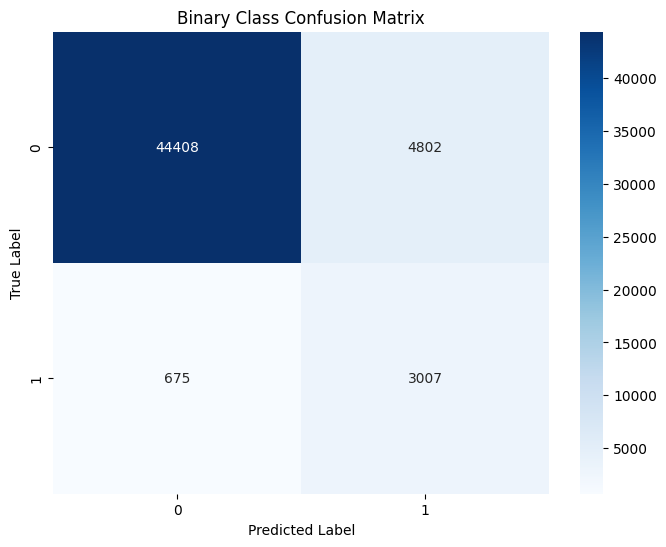

In [17]:
cm = confusion_matrix(y_test,preds)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Binary Class Confusion Matrix')
#disp.plot()
plt.savefig(file_path+'result/Cust_Affected_confusion_matrix.png')
plt.show()
plt.close() # Close the plot to free memory

pd.DataFrame(cm).to_csv(file_path+'result/Cust_Affected_confusion_matrix.csv')

In [19]:
report_dict = classification_report(y_test, preds, output_dict=True)
print(classification_report(y_test, preds))


pd.DataFrame(report_dict).transpose().to_csv(file_path+'result/Cust_Affected_classification_report.csv')


              precision    recall  f1-score   support

           0       0.99      0.90      0.94     49210
           1       0.39      0.82      0.52      3682

    accuracy                           0.90     52892
   macro avg       0.69      0.86      0.73     52892
weighted avg       0.94      0.90      0.91     52892



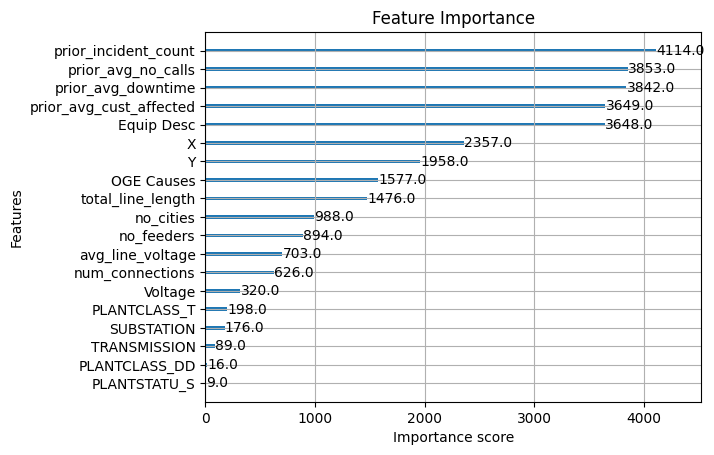

In [20]:

xgb.plot_importance(final_model)
plt.title("Feature Importance")
plt.savefig(file_path+'result/Cust_Affected_feature_importance.png')
plt.show()
plt.close()


In [82]:
from statistics import mode  
mode_function = (lambda x: mode(x))


In [83]:
file_path = 'Data/'
data = pd.read_csv(file_path+'CompleteData_withPriorInfov2.csv',index_col=0)


C:\Users\kazim\AppData\Local\Temp\ipykernel_21596\2538428751.py:2: DtypeWarning: Columns (39,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path+'CompleteData_withPriorInfov2.csv',index_col=0)


In [84]:


data['Job OFF Time'] = pd.to_datetime(data['Job OFF Time'])
data['Job ON Time'] = pd.to_datetime(data['Job ON Time'])
data['Major Storm Event  Y (Yes) or N (No)'] = data['Major Storm Event  Y (Yes) or N (No)'].apply(lambda x: x.upper() if x=='y' else x)
data

,CAD_ID,Job Region,Job Area (DISTRICT),Job Substation,Job Feeder,Feeder ID,Job OFF Time,Job ON Time,Job Duration Mins,Custs Affected,...,PLANTSTATU,num_connections,avg_line_voltage,total_line_length,no_feeders,no_cities,prior_incident_count,prior_avg_cust_affected,prior_avg_downtime,prior_avg_no_calls
Job Display ID,,,,,,,,,,,,,,,,,,,,,
2007025521,PD-01052015-00003,NORTHEAST,MUSKOGEE,3109:HONOR HEIGHTS,HONOR_HEIGHTS_921,310921,2015-01-05 01:15:48,2015-01-05 03:18:22,123.00,1,...,A,2.0,69.000000,33.355030,2,6,0,0.000000,0.000000,0.000000
2007036289,PD-01312015-00084,NORTHEAST,MUSKOGEE,3109:HONOR HEIGHTS,HONOR_HEIGHTS_921,310921,2015-01-31 16:44:29,2015-01-31 17:48:56,64.00,1,...,A,2.0,69.000000,33.355030,2,6,1,1.000000,123.000000,2.000000
2007037817,PD-02032015-00086,NORTHEAST,MUSKOGEE,3109:HONOR HEIGHTS,HONOR_HEIGHTS_921,310921,2015-02-03 13:55:33,2015-02-03 20:11:09,376.00,16,...,A,2.0,69.000000,33.355030,2,6,2,1.000000,93.500000,1.500000
2007042993,PD-02202015-00006,NORTHEAST,MUSKOGEE,3109:HONOR HEIGHTS,HONOR_HEIGHTS_921,310921,2015-02-20 06:40:48,2015-02-20 11:01:39,261.00,2,...,A,2.0,69.000000,33.355030,2,6,3,6.000000,187.666667,1.666667
2007043706,NaN,NORTHEAST,MUSKOGEE,3109:HONOR HEIGHTS,HONOR_HEIGHTS_921,310921,2015-02-22 15:44:21,2015-02-22 17:10:26,86.00,22,...,A,2.0,69.000000,33.355030,2,6,4,5.000000,206.000000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2112.017338,PD-12292021-00052,ARKANSAS,FORT SMITH,9512:ADABELL ROAD,ADABELL_ROAD_1221,951221,2021-12-29 05:41:59,2021-12-29 08:10:00,148.02,1,...,A,1.0,161.000000,17.764776,3,1,896,30.823661,590.103661,12.488839
2007727453,PD-03012018-00674,ARKANSAS,FORT SMITH,9965:NORTON/ALCOA,NORTON/ALCOA 99,996599,2018-03-01 08:58:08,2018-03-01 11:29:52,152.00,1,...,A,3.0,145.666667,1.736750,1,1,0,0.000000,0.000000,0.000000
2007736412,PD-03292018-00360,ARKANSAS,FORT SMITH,9965:NORTON/ALCOA,NORTON/ALCOA 99,996599,2018-03-29 14:06:11,2018-03-29 16:01:47,116.00,1,...,A,3.0,145.666667,1.736750,1,1,1,1.000000,152.000000,1.000000


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289168 entries, 2007025521 to 2007932896
Data columns (total 69 columns):
 #   Column                                                                     Non-Null Count   Dtype         
---  ------                                                                     --------------   -----         
 0   CAD_ID                                                                     202391 non-null  object        
 1   Job Region                                                                 289168 non-null  object        
 2   Job Area (DISTRICT)                                                        289168 non-null  object        
 3   Job Substation                                                             289168 non-null  object        
 4   Job Feeder                                                                 289168 non-null  object        
 5   Feeder ID                                                                  289168 non-null  

In [86]:
#only use data for which number of incidents is large
label_counts = data['Job Substation'].value_counts()


In [87]:
labels_to_remove = label_counts[label_counts < 500].index #we set minimum number of incidents to 500 for a substation to be qualified
labels_to_remove

Index(['7435:MISSION HILL', '5508:BROWN OG AND E', '7608:TIGER CREEK',
       '7611:MORRISON TAP', '7614:KNIPE', '5108:WOLF CREEK', '9113:CAVANAUGH',
       '5712:JOLLYVILLE', '3314:PORUM', '5906:TISHOMINGO',
       ...
       '3131:MUSKOGEE WW', '4242:CONT BLACKS', '8224:XEROX', '8113:CHEMETRON',
       '7693:ARCO PL CUSHIN', '4211:GRANT COUNTY', '3217:POLECAT CREEK',
       '4265:STANDING BEAR', '7626:SKELLY PL CUSH', '5507:REBAR'],
      dtype='object', name='Job Substation', length=143)

### Create another dataframe with substations having at least 500 incidents

In [88]:
data_filtered = data[~data['Job Substation'].isin(labels_to_remove)]
len(data_filtered.index)

264458

In [89]:
# Calculate the percentage of null values for each column
null_percentages = data_filtered.isnull().sum() / len(data_filtered)
null_percentages

threshold_percentage =0.48 # 28 columns out of 55 are selected

#Get the names of columns that are below the threshold
selected_columns = null_percentages[null_percentages <= threshold_percentage].index.tolist()
selected_columns

['CAD_ID',
 'Job Region',
 'Job Area (DISTRICT)',
 'Job Substation',
 'Job Feeder',
 'Feeder ID',
 'Job OFF Time',
 'Job ON Time',
 'Job Duration Mins',
 'Custs Affected',
 'Call Qty',
 'CMI',
 'Cause ID',
 'Cause Desc',
 'Equip ID',
 'Equip Desc',
 'STRCTUR_NO/Job Device ID',
 'OGE Causes',
 'Major Storm Event  Y (Yes) or N (No)',
 'Distribution, Substation, Transmission',
 'Transmission Voltage (69kV, 138kV, 161kv) feeding distribution substation',
 'Month/Day/Year',
 'Year',
 'Job City_imputed',
 'Device Address_imputed',
 'Substation ID',
 'X',
 'Y',
 'Name',
 'Voltage',
 'PLANTCLASS',
 'PLANTSTATU',
 'num_connections',
 'avg_line_voltage',
 'total_line_length',
 'no_feeders',
 'no_cities',
 'prior_incident_count',
 'prior_avg_cust_affected',
 'prior_avg_downtime',
 'prior_avg_no_calls']

In [90]:
#next, we remove columns that are related to target variable
# selected_columns.remove('OGE Causes')
# selected_columns.remove('Cause Desc')
# selected_columns.remove('Equip Desc')
selected_columns.remove('Cause ID')
selected_columns.remove('Equip ID')

#remove columns that are redundant 
selected_columns.remove('Device Address_imputed')
selected_columns.remove('Job City_imputed')
selected_columns.remove( 'Month/Day/Year')
selected_columns.remove('Transmission Voltage (69kV, 138kV, 161kv) feeding distribution substation')
selected_columns.remove('Job Region')
selected_columns.remove('Job Area (DISTRICT)')
selected_columns.remove('Job Feeder')
selected_columns.remove('Feeder ID')
selected_columns.remove('Name')
selected_columns.remove('Substation ID')


#remove columns that have date as datatype
selected_columns.remove('Job ON Time')
#selected_columns.remove('Job OFF Time')

selected_columns


['CAD_ID',
 'Job Substation',
 'Job OFF Time',
 'Job Duration Mins',
 'Custs Affected',
 'Call Qty',
 'CMI',
 'Cause Desc',
 'Equip Desc',
 'STRCTUR_NO/Job Device ID',
 'OGE Causes',
 'Major Storm Event  Y (Yes) or N (No)',
 'Distribution, Substation, Transmission',
 'Year',
 'X',
 'Y',
 'Voltage',
 'PLANTCLASS',
 'PLANTSTATU',
 'num_connections',
 'avg_line_voltage',
 'total_line_length',
 'no_feeders',
 'no_cities',
 'prior_incident_count',
 'prior_avg_cust_affected',
 'prior_avg_downtime',
 'prior_avg_no_calls']

### Identify and remove (object) columns (from `selected_columns`) that have unique values more than 40% of the total data

In [91]:
#compute percentage of unique values per column
nunique_percentages = data_filtered[selected_columns].nunique() / len(data_filtered)
nunique_percentages

CAD_ID                                    0.696519
Job Substation                            0.000734
Job OFF Time                              0.960595
Job Duration Mins                         0.176368
Custs Affected                            0.010070
Call Qty                                  0.003959
CMI                                       0.301802
Cause Desc                                0.000204
Equip Desc                                0.000397
STRCTUR_NO/Job Device ID                  0.481067
OGE Causes                                0.000026
Major Storm Event  Y (Yes) or N (No)      0.000015
Distribution, Substation, Transmission    0.000011
Year                                      0.000026
X                                         0.000734
Y                                         0.000734
Voltage                                   0.000015
PLANTCLASS                                0.000011
PLANTSTATU                                0.000008
num_connections                

In [92]:
data_filtered[selected_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 264458 entries, 2007025521 to J2112.017338
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   CAD_ID                                  184243 non-null  object        
 1   Job Substation                          264458 non-null  object        
 2   Job OFF Time                            264458 non-null  datetime64[ns]
 3   Job Duration Mins                       264458 non-null  float64       
 4   Custs Affected                          264458 non-null  int64         
 5   Call Qty                                264410 non-null  float64       
 6   CMI                                     253750 non-null  float64       
 7   Cause Desc                              263532 non-null  object        
 8   Equip Desc                              263569 non-null  object        
 9   STRCTUR_NO/Job Device ID   

In [93]:
#we remove columns that have too many unique values (more than 40% of the total no of rows) and are object data type
numeric_columns = data_filtered[selected_columns].select_dtypes(include=['datetime64[ns]','number'])

#all that are not in object_columns 
selected_columns = list(set([x for x in selected_columns if nunique_percentages[x]<=0.40 or x in numeric_columns.columns.tolist()]))
selected_columns

['Y',
 'Custs Affected',
 'Year',
 'Voltage',
 'Job Substation',
 'CMI',
 'avg_line_voltage',
 'no_feeders',
 'PLANTCLASS',
 'Call Qty',
 'Job Duration Mins',
 'prior_avg_downtime',
 'no_cities',
 'Equip Desc',
 'prior_incident_count',
 'Distribution, Substation, Transmission',
 'X',
 'num_connections',
 'Job OFF Time',
 'total_line_length',
 'prior_avg_no_calls',
 'Major Storm Event  Y (Yes) or N (No)',
 'prior_avg_cust_affected',
 'Cause Desc',
 'PLANTSTATU',
 'OGE Causes']

In [94]:
type(selected_columns)

list

In [95]:
data_filtered[selected_columns].describe()

,Y,Custs Affected,Year,Voltage,CMI,avg_line_voltage,no_feeders,Call Qty,Job Duration Mins,prior_avg_downtime,no_cities,prior_incident_count,X,num_connections,Job OFF Time,total_line_length,prior_avg_no_calls,prior_avg_cust_affected
count,264458.000000,264458.000000,264458.000000,264458.000000,2.537500e+05,264458.000000,264458.000000,264410.000000,264458.000000,264458.000000,264458.000000,264458.000000,264458.000000,264458.000000,264458,264458.000000,264410.000000,264458.000000
mean,35.432899,66.100704,2018.851379,122.653998,2.765420e+04,103.062947,4.656785,12.379778,479.100169,454.750157,4.104054,936.939121,-96.977684,2.467878,2019-05-27 01:24:12.929315584,106.704273,15.092569,53.306258
min,33.881328,1.000000,2015.000000,69.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-99.872027,0.000000,2015-01-01 01:04:40,0.000000,0.000000,0.000000
25%,35.342974,1.000000,2017.000000,69.000000,7.800000e+01,69.000000,3.000000,1.000000,55.330000,255.892160,2.000000,340.000000,-97.566118,1.000000,2017-10-24 08:44:57.750000128,13.671128,9.916036,32.159906
50%,35.479037,1.000000,2020.000000,138.000000,2.600000e+02,120.750000,4.000000,1.000000,120.000000,371.541161,3.000000,705.000000,-97.451440,2.000000,2020-02-03 17:41:12,60.601763,13.667841,48.659216
75%,35.579629,9.000000,2020.000000,138.000000,1.760000e+03,138.000000,6.000000,5.000000,285.000000,609.739163,6.000000,1306.000000,-96.672533,3.000000,2020-11-24 09:11:16.249999872,140.000423,17.648627,67.304901
max,36.818563,13590.000000,2021.000000,345.000000,9.476738e+07,293.250000,13.000000,5147.000000,259695.000000,10004.238095,14.000000,5043.000000,-93.574552,27.000000,2021-12-31 23:59:30,868.204023,1177.000000,2290.000000
std,0.487178,298.436912,1.963657,38.561812,5.256241e+05,51.004265,2.225559,66.392603,1755.516957,266.806422,3.048497,815.037895,1.081220,2.300270,NaN,135.173188,9.775651,31.521889


In [96]:
data_filtered[selected_columns].nunique() / len(data_filtered)


Y                                         0.000734
Custs Affected                            0.010070
Year                                      0.000026
Voltage                                   0.000015
Job Substation                            0.000734
CMI                                       0.301802
avg_line_voltage                          0.000087
no_feeders                                0.000042
PLANTCLASS                                0.000011
Call Qty                                  0.003959
Job Duration Mins                         0.176368
prior_avg_downtime                        0.981351
no_cities                                 0.000049
Equip Desc                                0.000397
prior_incident_count                      0.019043
Distribution, Substation, Transmission    0.000011
X                                         0.000734
num_connections                           0.000042
Job OFF Time                              0.960595
total_line_length              

In [97]:
data_filtered.loc[:,['OGE Cause_detail']] = data_filtered.apply(lambda row: row['OGE Causes'] if row['OGE Causes']!='Cause Exclusion' else row['Cause Desc'],axis=1)


class_mapping2 = {'Equipment': 1,
 'CUSTOMER EQUIPMENT': 1,
 'ON UPON ARRIVAL': 1,
 'DAMAGED BY PUBLIC': 1,
 'BREAKER': 1,
 'SEALED OUT/OPEN': 1,
 'CANCELLED': 1,
 'SUBSTATION OPERATION': 1,
 'Other': 0,
 'Blank': 0,
 'Animals': 0,
 'Vegetation': 0,
 'Weather': 0,}

data_filtered.loc[:,['Classes_2']] = data_filtered['OGE Cause_detail'].map(class_mapping)

In [98]:
data_filtered.columns

Index(['CAD_ID', 'Job Region', 'Job Area (DISTRICT)', 'Job Substation',
       'Job Feeder', 'Feeder ID', 'Job OFF Time', 'Job ON Time',
       'Job Duration Mins', 'Custs Affected', 'Call Qty', 'CMI', 'Cause ID',
       'Cause Desc', 'Equip ID', 'Equip Desc', 'Job City', 'Device Address',
       'CMI Category', 'Exclude CMI?', 'Job QA?', 'Event Exclusion?',
       'Total System Premises', 'Total Region Premises', 'Total Area Premises',
       'Total Subst Premises', 'Total Feeder Premises', 'Job SAIDI',
       'Job SAIFI', 'Job CAIDI', 'Job ASAI', 'Call Code', 'Extent',
       'STRCTUR_NO/Job Device ID', 'Device Type', 'Dev Subtype', 'Lead Crew',
       'Lead Crew Phone', 'Region SAIDI', 'Area SAIDI', 'Subst SAIDI',
       'Feeder SAIDI', 'AM Notes', 'OGE Causes',
       'Major Storm Event  Y (Yes) or N (No)',
       'Distribution, Substation, Transmission',
       'Transmission Voltage (69kV, 138kV, 161kv) feeding distribution substation',
       'Month/Day/Year', 'Year',
       'Equ

In [99]:
def calculate_entropy(series):
    """
    Calculates the entropy of a single pandas Series.
    Entropy H(X) = - sum(p(x) * log2(p(x)))
    """
    value_counts = series.value_counts(normalize=True)
    return entropy(value_counts, base=2)

def calculate_conditional_entropy(df, target_column, condition_column,n_bins_condition=5):
    """
    Calculates the conditional entropy H(Target | Condition) for two columns in a DataFrame.
    H(Y|X) = sum(p(x) * H(Y|X=x))
    """
    # Create a temporary DataFrame to work with, preserving the original
    temp_df = df.copy()
       
    # Only bin if there are enough unique values to make binning meaningful
    if pd.api.types.is_numeric_dtype(df[condition_column]) and temp_df[condition_column].nunique() > n_bins_condition:
        
         # Drop NaNs temporarily for binning to ensure bins are based on valid data
         temp_series_for_binning = temp_df[condition_column].dropna()

         binned_series = pd.qcut(temp_series_for_binning, q=n_bins_condition, 
                                                labels=False, duplicates='drop')
         # Overwrite the original condition column in temp_df with the binned version
         #  Use reindex to ensure NaNs from original are preserved
         temp_df[condition_column] = binned_series.reindex(temp_df.index)
         print(f"  Info: Binned numeric condition column '{condition_column}' into {temp_df[condition_column].nunique()} bins.")


    conditional_entropies = []
    # Get unique values of the condition column
    for condition_value in temp_df[condition_column].unique():
        # Subset the DataFrame where the condition column equals the current value
        subset_df = temp_df[temp_df[condition_column] == condition_value]
        # Calculate the probability of this condition value
        p_x = len(subset_df) / len(temp_df)
        # Calculate the entropy of the target column within this subset
        entropy_y_given_x = calculate_entropy(subset_df[target_column])
        conditional_entropies.append(p_x * entropy_y_given_x)

    return sum(conditional_entropies)

In [100]:

# # Computes entropy for a specific target column and its conditional entropy
# # given each of a list of feature columns (selected_columns)

# target_column ='Classes_2'
# # --- Compute Entropy of the Target Variable ---
# print("\n--- Entropy of Target Variable ---")
# entropy_target = calculate_entropy(data_filtered[target_column])  
# print(f"Entropy of '{target_column}': {entropy_target:.4f} bits")
      
# # --- Compute Conditional Entropies ---
# conditional_entropies = {}
# print(f"\n--- Conditional Entropies H({target_column} | Feature) ---")

# for feature_col in selected_columns:
#     if(feature_col == target_column or feature_col== 'Substation ID'):
#         continue
#    # key = f"H({target_column}|{feature_col})"
#     key = feature_col    
#     # For conditional entropy, we need to drop rows where *either* target or feature is NaN
#     # This ensures p(x) and H(Y|X=x) are calculated on consistent subsets
#     temp_df = data_filtered[[target_column, feature_col]].dropna() #removing NaN values
#     cond_ent = calculate_conditional_entropy(temp_df, target_column, feature_col)
#     conditional_entropies[key] = cond_ent
#     print(f"Conditional Entropy H({target_column}| {key}): {cond_ent:.4f} bits")

# # entropy_target: its the entropy of the target column, i.e. target_column
# # conditional_entropies dictionary containing conditional entropies
    


--- Entropy of Target Variable ---
Entropy of 'Classes': 0.9993 bits

--- Conditional Entropies H(Classes | Feature) ---
  Info: Binned numeric condition column 'Y' into 5 bins.
Conditional Entropy H(Classes| Y): 0.9953 bits
  Info: Binned numeric condition column 'Custs Affected' into 3 bins.
Conditional Entropy H(Classes| Custs Affected): 0.9792 bits
  Info: Binned numeric condition column 'Year' into 4 bins.
Conditional Entropy H(Classes| Year): 0.9237 bits
Conditional Entropy H(Classes| Voltage): 0.9983 bits
Conditional Entropy H(Classes| Job Substation): 0.9744 bits
  Info: Binned numeric condition column 'CMI' into 5 bins.
Conditional Entropy H(Classes| CMI): 0.9158 bits
  Info: Binned numeric condition column 'avg_line_voltage' into 4 bins.
Conditional Entropy H(Classes| avg_line_voltage): 0.9988 bits
  Info: Binned numeric condition column 'no_feeders' into 5 bins.
Conditional Entropy H(Classes| no_feeders): 0.9923 bits
Conditional Entropy H(Classes| PLANTCLASS): 0.9988 bits
 

KeyboardInterrupt: 

In [ ]:
# #compute information gain
# for key in conditional_entropies:
#     print(f'Information Gain (in) for {key} is {(entropy_target-conditional_entropies[key])}')

In [ ]:
# data_filtered[selected_columns].info()

In [ ]:
# sorted_data = dict(sorted(conditional_entropies.items(), key=lambda item: item[1]))
# plt.figure(figsize=(10,6))
# plt.plot(sorted_data.keys(),[sorted_data[i] for i in sorted_data.keys()])
# plt.axhline(y=entropy_target, color='red', linestyle='--')#, label='target class entropy')

# plt.grid(True)
# plt.xticks(rotation = 45,fontsize='x-small',horizontalalignment='right')
# # plt.yticks(np.arange(1.77,2, step = 0.005))
# plt.show()

In [ ]:
#remove all features where the conditional entropy is higher than 1.985 (the target's entropy is 1.9873)
#final_data = [cols for cols in selected_columns if conditional_entropies[cols]<1.985]


In [101]:
#add substation ID, Classes back into the columns data
final_data = selected_columns.copy()#no feature elimination due to entropy
final_data.insert(0,'Substation ID')
final_data.append('Classes_2')

In [102]:
data_filtered[final_data].info()

<class 'pandas.core.frame.DataFrame'>
Index: 264458 entries, 2007025521 to J2112.017338
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Substation ID                           264458 non-null  int64         
 1   Y                                       264458 non-null  float64       
 2   Custs Affected                          264458 non-null  int64         
 3   Year                                    264458 non-null  int64         
 4   Voltage                                 264458 non-null  float64       
 5   Job Substation                          264458 non-null  object        
 6   CMI                                     253750 non-null  float64       
 7   avg_line_voltage                        264458 non-null  float64       
 8   no_feeders                              264458 non-null  int64         
 9   PLANTCLASS                 

In [80]:
data_filtered[final_data].to_csv(file_path+'IncidentData_2classes.csv',index=False)


In [48]:
# data_merge.info()

In [49]:
#compute time sensitive incident data from incident file
#for each of the features, pick how many incidents before this incident, then compute these statistics for those incidents only
#per substation 

def gather_prior_incidents_by_substation(substation_ID, incident_df):
    inc_df = incident_df.copy()
    per_substation = inc_df.loc[inc_df['Substation ID']==substation_ID]
    # print('='*50)
    # print(f'Number of incidents of substation: {substation_ID}',per_substation.shape[0])
    #for each row of incident, find all rows that happened before that row 
    for i,(index,row) in enumerate(per_substation.iterrows()):
        prior_incidents = per_substation.loc[per_substation['Job OFF Time']<row['Job OFF Time']].sort_values(by='Job OFF Time')
        inc_df.loc[index, 'prior_incident_count']=prior_incidents.shape[0]
        inc_df.loc[index,'prior_avg_cust_affected']=prior_incidents['Custs Affected'].mean()
        inc_df.loc[index,'prior_avg_SAIFI']=prior_incidents['Job SAIFI'].mean()
        inc_df.loc[index,'prior_avg_downtown']=prior_incidents['Job Duration Mins'].mean()
        inc_df.loc[index,'prior_avg_no_calls']=prior_incidents['Call Qty'].mean()
        inc_df.loc[index,'prior_avg_cmi']=prior_incidents['CMI'].mean()
        #print(f'for iteration {i}, check the mean: {inc_df.loc[index,'prior_avg_cust_affected']}')
        #print(f'for incident {index}, the number of prior incidents are :{prior_incidents.shape[0]}')
    return inc_df #not needed but just if you want a return value

def gather_prior_incidents(incident_df):
    #get all the substations from the data
    #add columns with default value 
    incident_df.loc[:,['prior_incident_count','prior_avg_cust_affected','prior_avg_SAIFI','prior_avg_downtown','prior_avg_no_calls','prior_avg_cmi']]=0.0
    for Subs_ID in incident_df['Substation ID'].unique():
        #print(Subs_ID)
        incident_df= gather_prior_incidents_by_substation(Subs_ID,incident_df)
    return incident_df
    #time_sens_inc_features = ['incident_count', 'mean_SAIFI', 'avg_downtime','avg_cust_affected', 'avg_no_of_calls', 'avg_cmi','Major Storm Event  Y (Yes) or N (No)']

In [50]:
# data_merge = gather_prior_incidents(data_merge) #update the data_merge to add the new columns

In [51]:
# data_merge

In [52]:
# data_merge.to_csv(file_path+'Checkforaggregatedvalues.csv')

In [53]:
# data_merge.info]]

